## Filter Library Testing
*ph 16-10-2024*

Here we're just visualizing the equivalence between our filters and scipy counterparts. You can use the header-only library as is. To run this notebook, first compile a shared object with:
```
clang -fPIC -shared -o filter_test.so shim.c
```

In [5]:
import ctypes
import numpy as np
import scipy
import matplotlib.pyplot as plt

lib = ctypes.CDLL("./filter_test.so")

t = np.linspace(0, 2 * np.pi * 5, 1000)
signal = np.sin(t) + np.random.normal(scale=0.1, size=t.size)

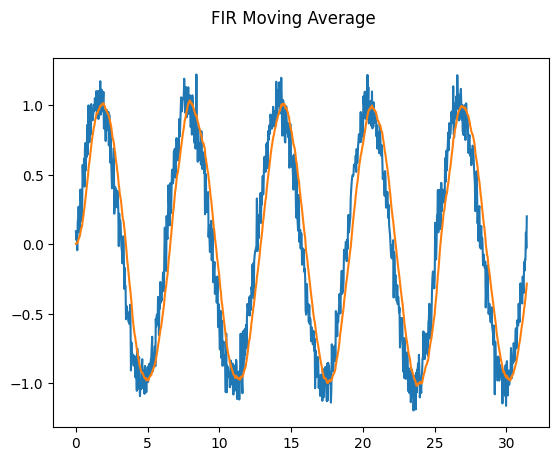

In [6]:
def fir(N, b, signal):
    lib.s_fir_filt.argtypes = [
        ctypes.c_double,
        ctypes.c_uint,
        np.ctypeslib.ndpointer(dtype=np.double, ndim=1, flags="C_CONTIGUOUS"),
        ctypes.POINTER(ctypes.c_uint),
        ctypes.c_char_p,
    ]
    lib.s_fir_filt.restype = ctypes.c_double

    # x_b must be of size N - 1, so sizeof(double) * (N - 1) bytes
    x_b = ctypes.create_string_buffer(ctypes.sizeof(ctypes.c_double) * (N - 1))
    idx = ctypes.c_uint(0)
    return [
        lib.s_fir_filt(
            ctypes.c_double(x),
            ctypes.c_uint(N),
            np.array(b),
            ctypes.byref(idx),
            x_b,
        )
        for x in signal
    ]


fig, ax = plt.subplots()
ax.plot(t, signal)
N = 20
b = [1.0 / N for i in range(N)]
ax.plot(t, fir(N, b, signal))
fig.suptitle("FIR Moving Average")
plt.show()

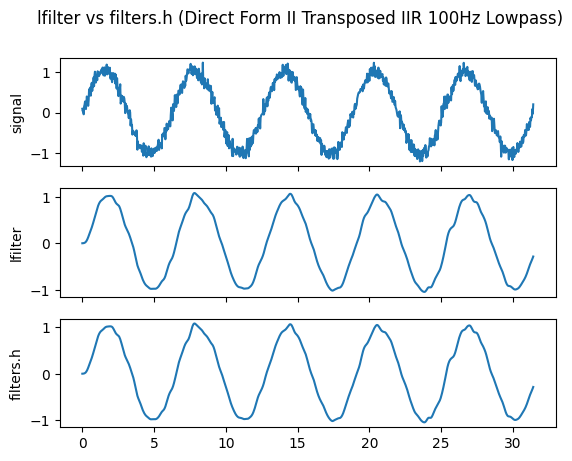

In [7]:
def iir_dfiit(N, b, a, signal):
    lib.s_iir_dfiit_filt.argtypes = [
        ctypes.c_double,
        ctypes.c_uint,
        np.ctypeslib.ndpointer(dtype=np.double, ndim=1, flags="C_CONTIGUOUS"),
        np.ctypeslib.ndpointer(dtype=np.double, ndim=1, flags="C_CONTIGUOUS"),
        ctypes.c_char_p,
    ]
    lib.s_iir_dfiit_filt.restype = ctypes.c_double

    s = ctypes.create_string_buffer(ctypes.sizeof(ctypes.c_double) * (N - 1))
    return [
        lib.s_iir_dfiit_filt(
            ctypes.c_double(x), ctypes.c_uint(N), np.array(b), np.array(a), s
        )
        for x in signal
    ]


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
ax1.plot(t, signal)
ax1.set_ylabel("signal")

b, a = scipy.signal.butter(N=4, Wn=0.1, btype="lowpass", output="ba")
ax2.plot(t, scipy.signal.lfilter(b, a, signal))
ax2.set_ylabel("lfilter")

ax3.plot(t, iir_dfiit(b.size, b, a, signal))
ax3.set_ylabel("filters.h")

fig.suptitle("lfilter vs filters.h (Direct Form II Transposed IIR 100Hz Lowpass)")
plt.show()

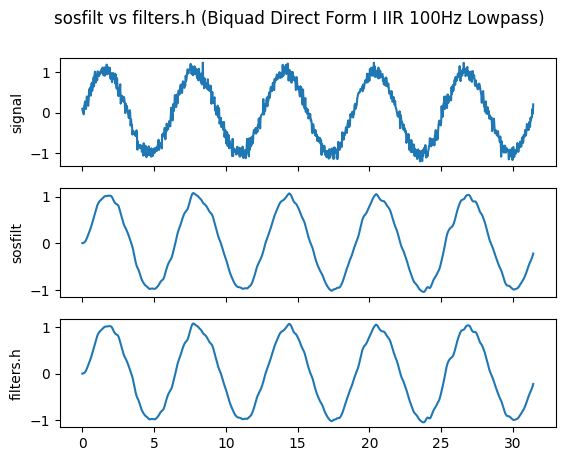

In [ ]:
def sos_dfi(Nstages, sos, signal):
    lib.s_sos_dfi_filt.argtypes = [
        ctypes.c_double,
        ctypes.c_uint,
        np.ctypeslib.ndpointer(dtype=np.double, ndim=1, flags="C_CONTIGUOUS"),
        ctypes.c_char_p,
    ]
    lib.s_sos_dfi_filt.restype = ctypes.c_double

    s = ctypes.create_string_buffer(ctypes.sizeof(ctypes.c_double) * Nstages * 4)
    return [
        lib.s_sos_dfi_filt(ctypes.c_double(x), ctypes.c_uint(Nstages), np.array(sos), s)
        for x in signal
    ]


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
ax1.plot(t, signal)
ax1.set_ylabel("signal")

sos = scipy.signal.butter(N=3, Wn=0.1, btype="lowpass", output="sos")
ax2.plot(t, scipy.signal.sosfilt(sos, signal))
ax2.set_ylabel("sosfilt")

ax3.plot(t, sos_dfi(sos.shape[0], np.ndarray.flatten(sos), signal))
ax3.set_ylabel("filters.h")

fig.suptitle("sosfilt vs filters.h (Biquad Direct Form I IIR 100Hz Lowpass)")
plt.show()